# Подгрузка библиотек и датасета

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\Nurlan\anaconda\envs\coursework\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("cardio_train.csv",sep=";")

In [3]:
df.drop("id",axis=1,inplace=True)
df.drop_duplicates(inplace=True)

# Анализ датасета

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Чтобы изучить все наши переменные, сначала мы должны посмотреть на их типы данных.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69976 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int64  
 1   gender       69976 non-null  int64  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


Видно, что в датасете пропущенных значений нет

Все признаки количественные, 12 целых и 1 вещественных (вес). Второй столбец дает нам представление о том, насколько велик набор данных и сколько ненулевых значений имеется для каждого поля. Мы можем использовать describe() для отображения выборочной статистики, такой как минимум, максимум, среднее, стандартное отклонение для каждого атрибута:

In [6]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Из приведенной выше таблицы describe видно, что в ap_hi, ap_lo, весе и росте есть выбросы. Мы займемся ими позже.

## Очистка

Если мы более внимательно посмотрим на столбцы роста и веса, то заметим, что минимальный рост составляет 55 см, а минимальный вес — 10 кг. Это должно быть ошибкой, так как минимальный возраст составляет 10798 дней, что равно 29 годам. С другой стороны, максимальный рост составляет 250 см, а максимальный вес — 200 кг, что может не иметь значения при обобщении данных. Чтобы справиться с этими ошибками, мы можем удалить выбросы.

In [7]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Удалим вес и рост, которые меньше 2,5% или больше 97,5% от всего интервала значений.

In [8]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

Кроме того, в ряде случаев диастолическое давление выше систолического, что также неверно. Сколько записей неточны с точки зрения артериального давления?

In [9]:
print(f"Diastilic pressure is higher than systolic one in {df[df['ap_lo']> df['ap_hi']].shape[0]} cases")

Diastilic pressure is higher than systolic one in 1082 cases


Давайте избавимся от выбросов, тем более артериальное давление не может быть отрицательным значением!

In [10]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

Diastilic pressure is higher than systolic one in 0 cases


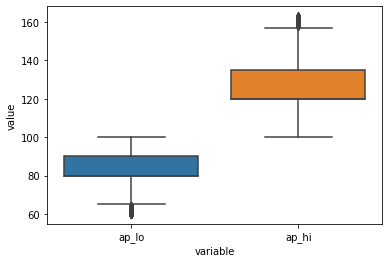

In [11]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print(f"Diastilic pressure is higher than systolic one in {df[df['ap_lo']> df['ap_hi']].shape[0]} cases")

## Продолжение анализа

Рассмотрим распределение целевой переменной

In [12]:
df['cardio'].value_counts(normalize=True)

0    0.511694
1    0.488306
Name: cardio, dtype: float64

Можно заметить, что классы распределены одинаково

Возраст измеряется в днях, рост в сантиметрах. Давайте посмотрим на числовые переменные и на то, как они распределены по целевому классу. Например, в каком возрасте количество людей с сердечно-сосудистыми заболеваниями превышает количество людей без ССЗ?

<AxesSubplot:xlabel='years', ylabel='count'>

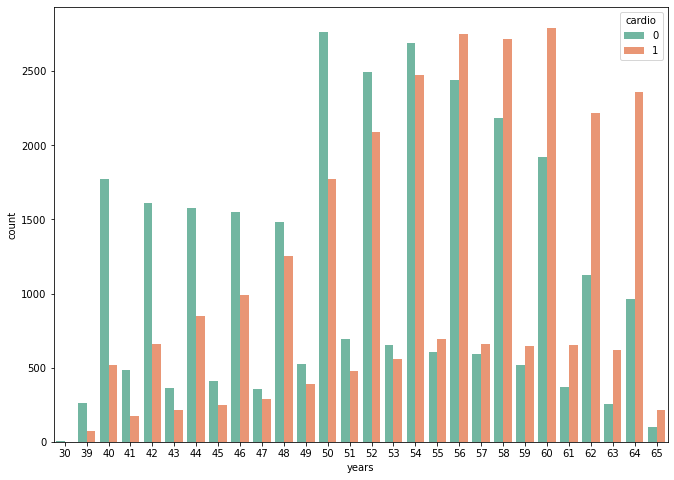

In [13]:
rcParams['figure.figsize'] = 11, 8
df['years'] = (df['age'] / 365).round().astype('int')
sns.countplot(x='years', hue='cardio', data = df, palette="Set2")

Можно заметить, что люди старше 55 лет более подвержены сердечно-сосудистым заболеваниям

Давайте посмотрим на категориальные переменные в наборе данных и их распределение:

<AxesSubplot:xlabel='variable', ylabel='count'>

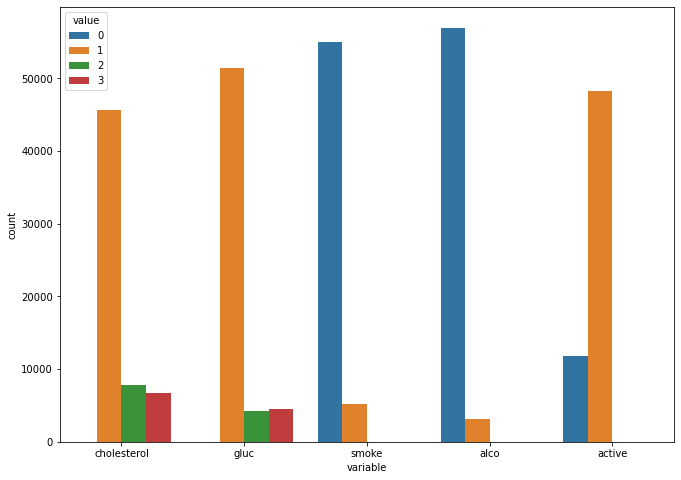

In [14]:
df_categorical = df.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical))

Может быть полезно разделить категориальные переменные по целевому классу:

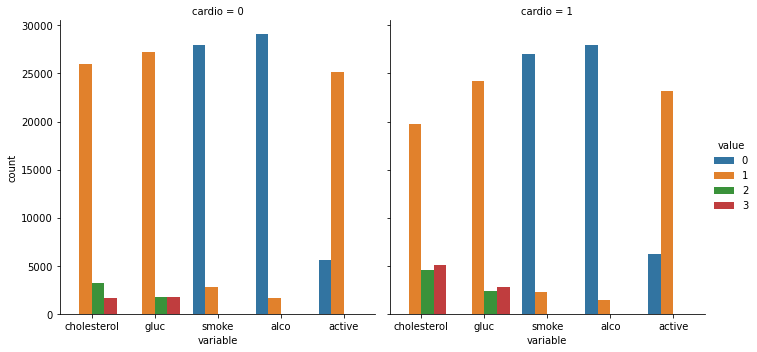

In [15]:
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio", data=df_long, kind="count")

Отчетливо видно, что у пациентов с ССЗ повышен уровень холестерина и глюкозы в крови. И, вообще говоря, менее они активны.

Чтобы выяснить, что означает «1» в столбце пола, давайте рассчитаем среднее значение роста для каждого пола. Мы предполагаем, что мужчины в среднем выше, чем женщины.

In [16]:
df.groupby('gender')['height'].mean()

gender
1    162.054342
2    169.252095
Name: height, dtype: float64

Средний рост для пола «2» больше, чем для пола «1», поэтому «1» скорее всего женщины. Давайте посмотрим, сколько мужчин и женщин представлено в датасете:

In [17]:
df['gender'].value_counts()

1    39233
2    20885
Name: gender, dtype: int64

Давайте создадим violinplot график, чтобы показать распределение роста по полу. Взгляда на средние значения роста и веса для каждого значения признака пола может быть недостаточно, чтобы определить, является ли 1 мужским или женским обозначением.

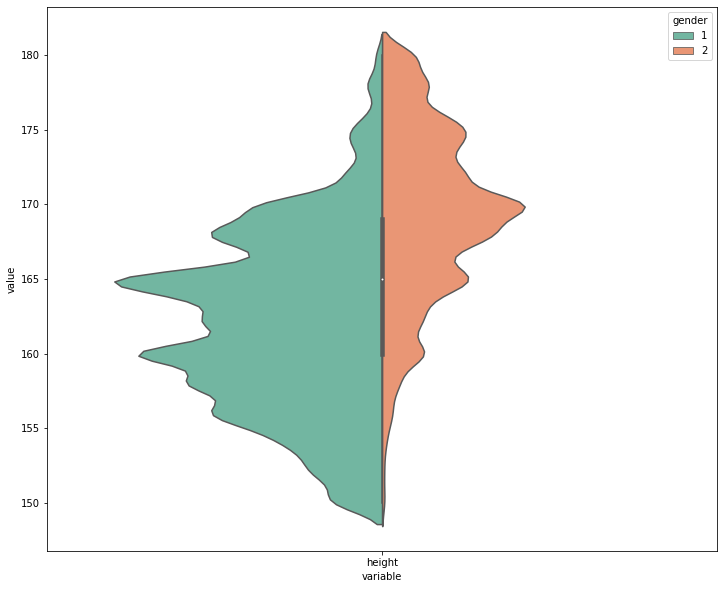

In [18]:
import warnings
warnings.filterwarnings("ignore")
df_melt = pd.melt(frame=df, value_vars=['height'], id_vars=['gender'])
plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    split=True, 
    data=df_melt, 
    scale='count',
    scale_hue=False,
    palette="Set2");

Кто чаще употребляет алкоголь - мужчины или женщины?

In [19]:
df.groupby('gender')['alco'].sum()

gender
1     973
2    2147
Name: alco, dtype: int64

Так, мужчины в среднем чаще употребляют алкоголь.

Чтобы увидеть, как целевой класс распределяется среди мужчин и женщин, мы также можем использовать кросс-таблицу

In [20]:
pd.crosstab(df['cardio'],df['gender'],normalize=True)

gender,1,2
cardio,,
0,0.332762,0.178931
1,0.319838,0.168469


Также можем посмотреть на матрицу корреляций

<AxesSubplot:>

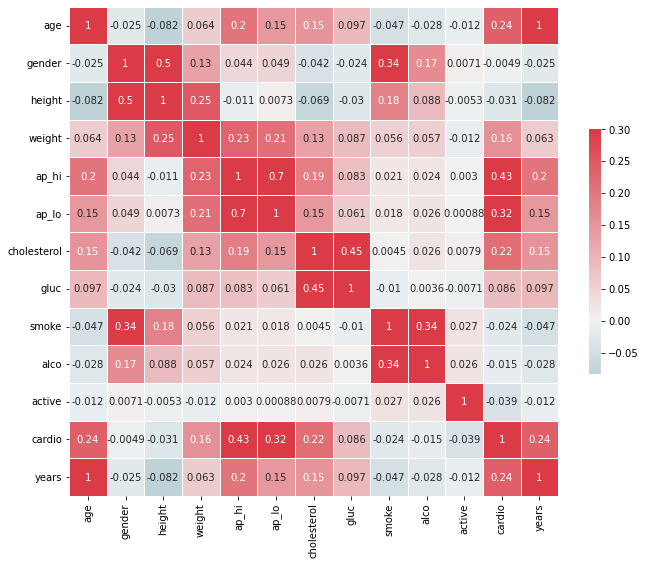

In [21]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## BMI

Давайте создадим новый признак - Индекс Массы Тела (ИМТ):


<center>$\text{BMI} = \frac{\text{mass}_{\text{kg}}}{\text{height}_{m}^2}$<center>

    
и сравним средний ИМТ здоровых людей со средним ИМТ больных людей. Считается, что нормальные значения ИМТ находятся в пределах от 18,5 до 25.

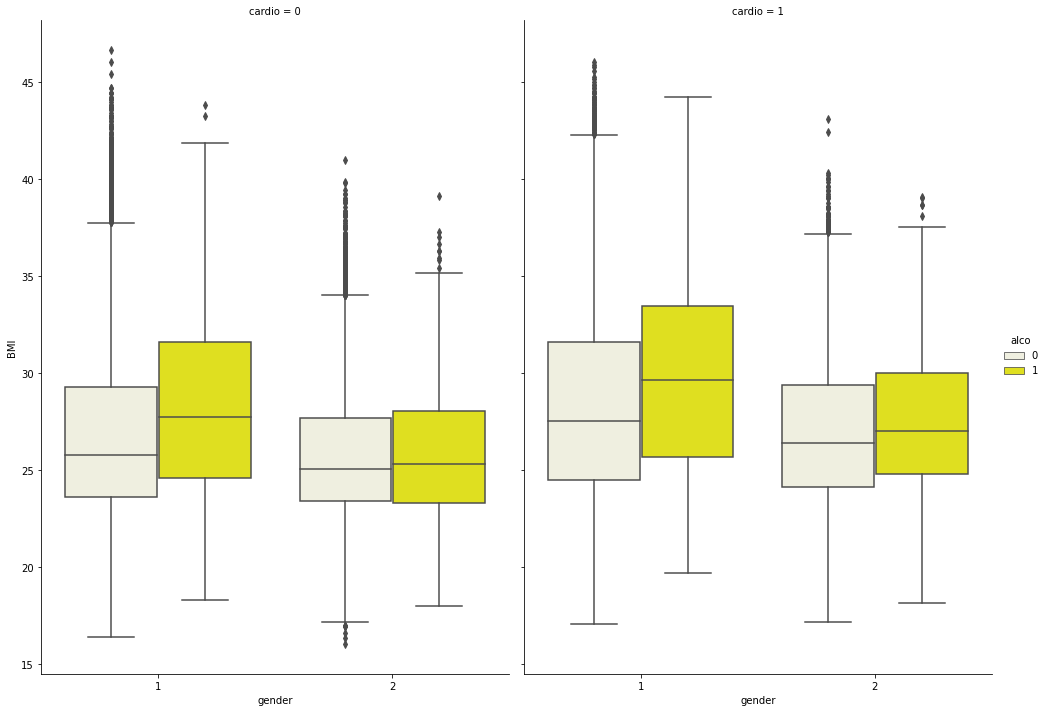

In [22]:
df['BMI'] = df['weight']/((df['height']/100)**2)
sns.catplot(x="gender", y="BMI", hue="alco", col="cardio", data=df, color = "yellow",kind="box", height=10, aspect=.7);

По ИМТ пьющие женщины имеют более высокйи риск ССЗ, чем пьющие мужчины 

# Построение моделей

In [23]:
target_name = 'cardio'
data_target = df[target_name]
df = df.drop([target_name], axis=1)

Разделение на train/test

In [24]:
train, test, target, target_test = train_test_split(df, data_target, test_size=0.33, random_state=0)

In [52]:
train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,years,BMI
58117,15799,2,176,77.0,120,80,3,3,0,0,1,43,24.857955
23072,18148,2,167,95.0,130,80,1,1,1,0,1,50,34.063609
62921,22773,2,168,78.0,120,80,1,1,1,0,1,62,27.636054
61687,14707,1,156,78.0,110,70,1,1,0,0,1,40,32.051282
1489,20502,1,163,93.0,120,80,1,3,0,0,1,56,35.003199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53336,23294,1,153,66.0,120,80,3,2,0,0,1,64,28.194284
61002,23402,2,169,91.0,120,80,1,1,0,0,1,64,31.861629
49550,16771,1,165,65.0,120,80,1,1,0,0,1,46,23.875115
50662,22412,1,154,80.0,120,70,1,1,0,0,1,61,33.732501


# Logreg

In [33]:
scaler = MinMaxScaler()
logreg = LogisticRegression()
logreg_pipe = Pipeline(steps=[("scaler", scaler), ("logreg", logreg)])

In [34]:
param_grid = {'logreg__penalty' : ['l1', 'l2', 'none'],
              'logreg__C' : [100, 10, 1, 0.1, 0.01],
              'logreg__solver' : ['newton-cg', 'lbfgs', 'sag', 'liblinear']
             }

In [35]:
logreg_search = GridSearchCV(estimator=logreg_pipe, param_grid=param_grid, n_jobs=-1, cv=5, error_score=0)
logreg_best = logreg_search.fit(train, target)

In [36]:
logreg_best.best_params_

{'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}

In [37]:
pred = logreg_best.predict(test)

In [38]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74     10124
           1       0.75      0.65      0.70      9715

    accuracy                           0.72     19839
   macro avg       0.73      0.72      0.72     19839
weighted avg       0.73      0.72      0.72     19839



Сохранение модели

In [176]:
pickle.dump(logreg_best, open('logreg_best.pkl', 'wb'))

In [ ]:
# loaded_logreg = pickle.load(open('logreg_best.pkl', 'rb'))

Мы можем использовать логистическую регрессию для проверки наших предположений и решений для создания функций и достижения целей. Это можно сделать, рассчитав коэффициент признаков в решающей функции.

Положительные коэффициенты увеличивают логарифмические шансы ответа (и, таким образом, увеличивают вероятность), а отрицательные коэффициенты уменьшают логарифмические шансы ответа (и, таким образом, уменьшают вероятность).

глюк самый высокий коэффициент
высота, дым — самые большие числа по абсолютной величине.

# Linear SVC

In [130]:
scaler = MinMaxScaler()
svc = LinearSVC()
svc_pipe = Pipeline(steps=[("scaler", scaler), ("svc", svc)])

In [131]:
param_grid = {'svc__penalty' : ['l1', 'l2', 'none'],
              'svc__dual' : [False],
              'svc__loss' : ['hinge', 'squared_hinge'],
              'svc__C' : [100, 10, 1, 0.1, 0.01],
             }

In [132]:
svc_search = GridSearchCV(estimator=svc_pipe, param_grid=param_grid, n_jobs=-1, cv=5, error_score=0)
svc_best = svc_search.fit(train, target)

In [133]:
svc_best.best_params_

{'svc__C': 0.01,
 'svc__dual': False,
 'svc__loss': 'squared_hinge',
 'svc__penalty': 'l2'}

In [134]:
pred = svc_best.predict(test)

In [135]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75     10124
           1       0.75      0.64      0.69      9715

    accuracy                           0.72     19839
   macro avg       0.73      0.72      0.72     19839
weighted avg       0.73      0.72      0.72     19839



In [180]:
pickle.dump(svc_best, open('svc_best.pkl', 'wb'))

# K-nn

In [142]:
scaler = MinMaxScaler()
knn = KNeighborsClassifier()
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

In [143]:
param_grid = {'knn__n_neighbors' : [3, 5, 10, 15, 20, 30, 35],
              'knn__weights' : ['uniform', 'distance'],
             }

In [144]:
knn_search = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, n_jobs=-1, cv=5, error_score=0)
knn_best = knn_search.fit(train, target)

In [145]:
knn_best.best_params_

{'knn__n_neighbors': 35, 'knn__weights': 'uniform'}

In [146]:
pred = knn_best.predict(test)

In [147]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     10124
           1       0.74      0.67      0.70      9715

    accuracy                           0.72     19839
   macro avg       0.72      0.72      0.72     19839
weighted avg       0.72      0.72      0.72     19839



In [181]:
pickle.dump(knn_best, open('knn_best.pkl', 'wb'))

В распознавании образов алгоритм k-ближайших соседей (или сокращенно k-NN) представляет собой непараметрический метод, используемый для классификации и регрессии. Выборка классифицируется большинством голосов ее соседей, при этом выборка относится к классу, наиболее распространенному среди k ее ближайших соседей (k — положительное целое число, обычно маленькое).

# Random Forest

In [158]:
forest = RandomForestClassifier()

param_grid = {
#                 'n_estimators' : [10, 50, 100, 200, 500, 1000],
              'n_estimators' : [50, 100, 150],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [5, 10, 15],
              'max_features' : ['auto', 'log2'],
              'bootstrap' : [True, False],
              'min_samples_leaf' : [1, 2, 4],
              'min_samples_split' : [2, 3, 5],
             }

In [159]:
forest_search = GridSearchCV(estimator=forest, param_grid=param_grid, n_jobs=-1, cv=5, error_score=0, verbose=5)
forest_best = forest_search.fit(train, target)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [160]:
forest_best.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [161]:
pred = forest_best.predict(test)

In [163]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74     10124
           1       0.74      0.67      0.71      9715

    accuracy                           0.73     19839
   macro avg       0.73      0.73      0.73     19839
weighted avg       0.73      0.73      0.73     19839



In [182]:
pickle.dump(forest_best, open('forest_best.pkl', 'wb'))

# XGBoost

Для подбора лучших параметров для модели XGBoost была использована бибилотека 

In [195]:
space= {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
            'alpha' : hp.quniform('alpha', 40,180,1),
            'lambda' : hp.uniform('lambda', 0,1),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
        }

In [196]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    eta = space['eta'], 
                    reg_lambda = space['lambda'],
                    subsample = space['subsample'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    alpha = int(space['alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    objective = space['objective'],
                    booster = space['booster'],
                    tree_method = space['tree_method'],
#                     missing = space['missing'],
                    colsample_bytree=int(space['colsample_bytree']), )
    
    evaluation = [( train, target), ( test, target_test)]
    
    clf.fit(train, target,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(test)
    accuracy = accuracy_score(target_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [197]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 400,
                        trials = trials)

SCORE:                                                 
0.662533393820253                                      
SCORE:                                                                           
0.6847623368113313                                                               
SCORE:                                                                            
0.6887947981249055                                                                
SCORE:                                                                            
0.6785120217752911                                                                
SCORE:                                                                            
0.6723121125056707                                                                
SCORE:                                                                            
0.6653057109733354                                                                
SCORE:                                                      

0.673824285498261                                                                  
SCORE:                                                                             
0.676647008417763                                                                  
SCORE:                                                                             
0.676647008417763                                                                  
SCORE:                                                                              
0.6877866827965119                                                                  
SCORE:                                                                              
0.6804274408992389                                                                  
SCORE:                                                                              
0.6856192348404657                                                                  
SCORE:                                                                

0.7279096728665759                                                                  
SCORE:                                                                              
0.6621301476888957                                                                  
SCORE:                                                                              
0.6654569282725944                                                                  
SCORE:                                                                              
0.6546196884923635                                                                  
SCORE:                                                                              
0.6639447552800041                                                                  
SCORE:                                                                              
0.6688845203891325                                                                  
SCORE:                                                           

0.6760925449871465                                                                  
SCORE:                                                                              
0.6768990372498613                                                                  
SCORE:                                                                              
0.671152779878018                                                                   
SCORE:                                                                              
0.6775543122133172                                                                  
SCORE:                                                                              
0.6766974141841827                                                                  
SCORE:                                                                              
0.6748324008266545                                                                  
SCORE:                                                           

0.7288169766621302                                                                  
SCORE:                                                                              
0.6826957003881244                                                                  
SCORE:                                                                              
0.7274056152023791                                                                  
SCORE:                                                                              
0.6827965119209638                                                                  
SCORE:                                                                              
0.6833005695851605                                                                  
SCORE:                                                                              
0.683855033015777                                                                   
SCORE:                                                           

In [198]:
print(best_hyperparams)

{'alpha': 149.0, 'colsample_bytree': 1.0, 'eta': 0.32, 'gamma': 0.67, 'lambda': 0.5711731813185805, 'max_depth': 3, 'min_child_weight': 1.2750000000000001, 'n_estimators': 642, 'subsample': 0.785}


In [199]:
xgboost_best=xgb.XGBClassifier(**best_hyperparams)

In [200]:
evaluation = [( train, target), ( test, target_test)]
xgboost_best.fit(train, target, eval_set=evaluation, eval_metric="auc", early_stopping_rounds=10,verbose=False)
pred = xgboost_best.predict(test)

In [201]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     10124
           1       0.73      0.69      0.71      9715

    accuracy                           0.73     19839
   macro avg       0.73      0.73      0.73     19839
weighted avg       0.73      0.73      0.73     19839



In [202]:
pickle.dump(xgboost_best, open('xgboost_best.pkl', 'wb'))

In [204]:
pred = xgboost_best.predict(test)

In [ ]:
print(classification_report(target_test, pred))

# Voting

In [26]:
# loaded_logreg = pickle.load(open('logreg_best.pkl', 'rb'))
# loaded_svc = pickle.load(open('svc_best.pkl', 'rb'))
# loaded_knn = pickle.load(open('knn_best.pkl', 'rb'))
# loaded_forest = pickle.load(open('forest_best.pkl', 'rb'))
# loaded_xgb = pickle.load(open('xgboost_best.pkl', 'rb'))

In [36]:
logreg_params={'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
svc_params = {'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
knn_params = {'n_neighbors': 35, 'weights': 'uniform'}
rf_params = {'bootstrap': True,
             'criterion': 'gini',
             'max_depth': 10,
             'max_features': 'auto',
             'min_samples_leaf': 1,
             'min_samples_split': 5,
             'n_estimators': 50}
xgb_params = {'alpha': 149.0, 
              'colsample_bytree': 1.0, 
              'eta': 0.32, 'gamma': 0.67, 
              'lambda': 0.5711731813185805, 
              'max_depth': 3, 'min_child_weight': 1.2750000000000001, 
              'n_estimators': 642, 
              'subsample': 0.785}

In [37]:
scaler = MinMaxScaler()

logreg = LogisticRegression(**logreg_params)
logreg_pipe = Pipeline(steps=[("scaler", scaler), ("logreg", logreg)])

svc = LinearSVC(**svc_params)
svc_pipe = Pipeline(steps=[("scaler", scaler), ("svc", svc)])

knn = KNeighborsClassifier(**knn_params)
knn_pipe = Pipeline(steps=[("scaler", scaler), ("knn", knn)])

forest = RandomForestClassifier(**rf_params)

xgboost_best=xgb.XGBClassifier(**xgb_params)

In [53]:
Voting_Classifier_hard = VotingClassifier(estimators=[('logreg', logreg_pipe), ('rf', forest), ('xgb', xgboost_best)], voting='soft')

In [38]:
# Voting_Classifier_hard = VotingClassifier(estimators=[('logreg', loaded_logreg), ('svc', loaded_svc), ('knn', loaded_knn), ('rf', loaded_forest), ('xgb', loaded_xgb)], voting='hard')

In [54]:
Voting_Classifier_hard.fit(train, target)

[10:02:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('logreg',
                                               LogisticRegression(C=0.1,
                                                                  solver='newton-cg'))])),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=50)),
                             ('xgb',
                              XGBClassifier(alpha=149.0, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0,
                                            en

In [55]:
pred = Voting_Classifier_hard.predict(test)

In [56]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74     10124
           1       0.74      0.68      0.71      9715

    accuracy                           0.73     19839
   macro avg       0.73      0.73      0.73     19839
weighted avg       0.73      0.73      0.73     19839



In [57]:
pickle.dump(Voting_Classifier_hard, open('voting_final.pkl', 'wb'))